Klasifikasi : Algoritma Regressor berbasis model
- Lasso Regression
- Random Forest Regressor

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression

In [41]:
housing = pd.read_csv(r'C:\Users\pf34h\Downloads\UTS (2)\UTS\Dataset UTS_Gasal 2425 .csv')
print(housing.head(10))

   squaremeters  numberofrooms hasyard haspool  floors  citycode  \
0         75523              3      no     yes      63      9373   
1         55712             58      no     yes      19     34457   
2         86929            100     yes      no      11     98155   
3         51522              3      no      no      61      9047   
4         96470             74     yes      no      21     92029   
5         79770              3      no     yes      69     54812   
6         75985             60     yes      no      67      6517   
7         64169             88      no     yes       6     61711   
8         92383             12      no      no      78     71982   
9         95121             46      no     yes       3      9382   

   citypartrange  numprevowners  made isnewbuilt hasstormprotector  basement  \
0              3              8  2005        old               yes      4313   
1              6              8  2021        old                no      2937   
2          

In [42]:
print("Data Null:\n", housing.isnull().sum())
print("Data Kosong:", housing.empty)

Data Null:
 squaremeters         0
numberofrooms        0
hasyard              0
haspool              0
floors               0
citycode             0
citypartrange        0
numprevowners        0
made                 0
isnewbuilt           0
hasstormprotector    0
basement             0
attic                0
garage               0
hasstorageroom       0
hasguestroom         0
price                0
category             0
dtype: int64
Data Kosong: False


In [43]:
housing = housing.drop(['citycode', 'category'], axis=1)
print(housing.head(10))


   squaremeters  numberofrooms hasyard haspool  floors  citypartrange  \
0         75523              3      no     yes      63              3   
1         55712             58      no     yes      19              6   
2         86929            100     yes      no      11              3   
3         51522              3      no      no      61              8   
4         96470             74     yes      no      21              4   
5         79770              3      no     yes      69             10   
6         75985             60     yes      no      67              6   
7         64169             88      no     yes       6              3   
8         92383             12      no      no      78              3   
9         95121             46      no     yes       3              7   

   numprevowners  made isnewbuilt hasstormprotector  basement  attic  garage  \
0              8  2005        old               yes      4313   9005     956   
1              8  2021        old   

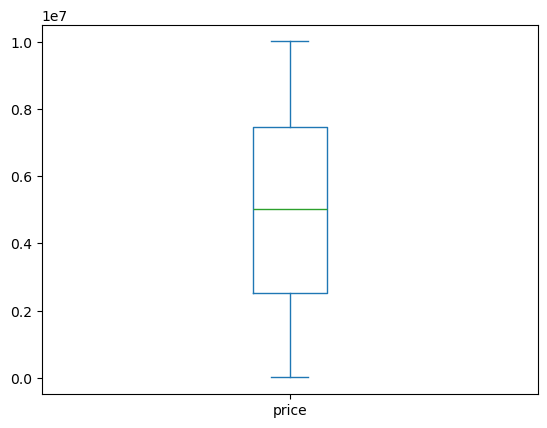

In [44]:
housing['price'].plot(kind='box')
plt.show()


In [45]:
def remove_outlier(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

housing_clean = remove_outlier(housing)
print("Jumlah baris sebelum:", housing.shape[0])
print("Jumlah baris sesudah:", housing_clean.shape[0])

Jumlah baris sebelum: 10000
Jumlah baris sesudah: 10000


In [46]:
X_regress = housing_clean.drop('price', axis=1)
y_regress = housing_clean['price']


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_regress, y_regress, test_size=0.2, random_state=72)


In [48]:
cat_cols = X_train.select_dtypes(include=['object']).columns
col_transformer = make_column_transformer((OneHotEncoder(), cat_cols), remainder='passthrough')

X_train_enc = col_transformer.fit_transform(X_train)
X_test_enc = col_transformer.transform(X_test)

In [66]:
pipe_lasso = Pipeline([
    ('scale', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)), 
    ('reg', Lasso(max_iter=1000)),
])

param_grid_lasso = {
    'scale': [MinMaxScaler(), StandardScaler()],
    'reg__alpha': [0.01, 0.1, 1, 10, 100],
    'feature_selection__k': np.arange(1, 20),
}

GSCV_Lasso = GridSearchCV(pipe_lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
GSCV_Lasso.fit(X_train_enc, y_train)

print("Best Model Lasso:", GSCV_Lasso.best_estimator_)
print("Koefisien:", GSCV_Lasso.best_estimator_.named_steps['reg'].coef_)
print("Intercept:", GSCV_Lasso.best_estimator_.named_steps['reg'].intercept_)


Best Model Lasso: Pipeline(steps=[('scale', StandardScaler()),
                ('feature_selection',
                 SelectKBest(k=19,
                             score_func=<function f_regression at 0x000001D58DEBF740>)),
                ('reg', Lasso(alpha=10))])
Koefisien: [-1.50538168e+03  0.00000000e+00 -1.48363148e+03  0.00000000e+00
  8.12763395e+01 -0.00000000e+00 -5.76955953e+01  3.27418093e-14
  0.00000000e+00 -0.00000000e+00  2.87987064e+06  0.00000000e+00
  1.57072110e+03  1.25244258e+02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  9.19615181e+00 -0.00000000e+00]
Intercept: 4979308.578425


In [74]:
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_regression)), 
    ('reg', RandomForestRegressor(random_state=72))
])

param_grid_rf = {
    'scale': [MinMaxScaler(), StandardScaler()],
    'reg__n_estimators': [100, 200],
    'reg__max_depth': [10, 20, None],
    'feature_selection__k': np.arange(1, 20),
}

GSCV_RF = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
GSCV_RF.fit(X_train_enc, y_train)

print("Best Model RF:", GSCV_RF.best_estimator_)


Best Model RF: Pipeline(steps=[('scale', MinMaxScaler()),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000001D58DEBF740>)),
                ('reg',
                 RandomForestRegressor(n_estimators=200, random_state=72))])


In [75]:
lasso_pred = GSCV_Lasso.predict(X_test_enc)
mse_lasso = mean_squared_error(y_test, lasso_pred)
mae_lasso = mean_absolute_error(y_test, lasso_pred)

print("Lasso MSE:", mse_lasso)
print("Lasso MAE:", mae_lasso)
print("Lasso RMSE:", np.sqrt(mse_lasso))


Lasso MSE: 3639329.1304730116
Lasso MAE: 1478.7234844071418
Lasso RMSE: 1907.7025791440897


In [76]:
rf_pred = GSCV_RF.predict(X_test_enc)
mse_rf = mean_squared_error(y_test, rf_pred)
mae_rf = mean_absolute_error(y_test, rf_pred)

print("RF MSE:", mse_rf)
print("RF MAE:", mae_rf)
print("RF RMSE:", np.sqrt(mse_rf))


RF MSE: 14905239.418717457
RF MAE: 3104.0755612500902
RF RMSE: 3860.730425543521


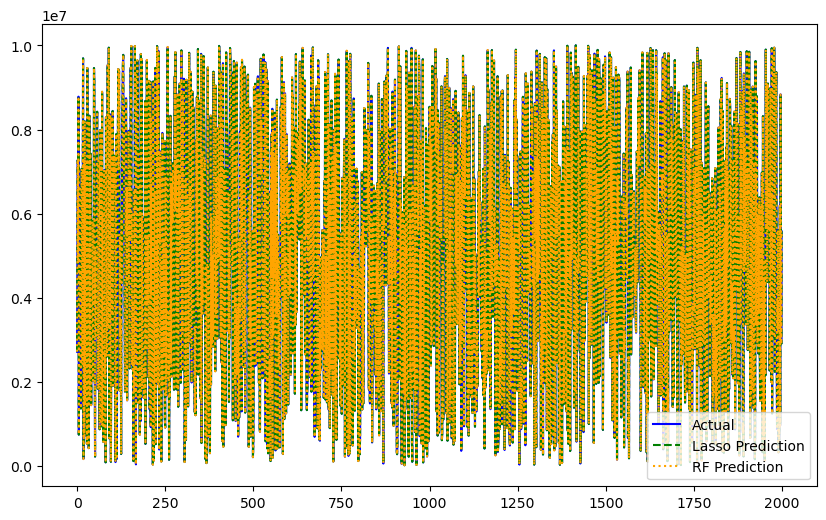

In [77]:
df_results = pd.DataFrame({'Actual': y_test, 'Lasso Prediction': lasso_pred, 'RF Prediction': rf_pred})

plt.figure(figsize=(10, 6))
plt.plot(df_results['Actual'].values, label='Actual', color='blue')
plt.plot(df_results['Lasso Prediction'].values, label='Lasso Prediction', linestyle='--', color='green')
plt.plot(df_results['RF Prediction'].values, label='RF Prediction', linestyle=':', color='orange')
plt.legend()
plt.show()


In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_lasso = mean_absolute_error(df_results['Actual'], df_results['Lasso Prediction'])
rmse_lasso = np.sqrt(mean_squared_error(df_results['Actual'], df_results['Lasso Prediction']))
lasso_feature_count = GSCV_Lasso.best_params_['feature_selection__k']

mae_rf = mean_absolute_error(df_results['Actual'], df_results['RF Prediction'])
rmse_rf = np.sqrt(mean_squared_error(df_results['Actual'], df_results['RF Prediction']))
rf_feature_count = GSCV_RF.best_params_['feature_selection__k']

print(f"Lasso MAE: {mae_lasso}, Lasso RMSE:  {rmse_lasso}, Lasso Feature Count: {lasso_feature_count}")
print(f"Random Forest MAE: {mae_rf}, Random Forest RMSE:  {rmse_rf}, Random Forest Feature Count: {rf_feature_count}")


Lasso MAE: 1478.7234844071418, Lasso RMSE:  1907.7025791440897, Lasso Feature Count: 19
Random Forest MAE: 3104.0755612500902, Random Forest RMSE:  3860.730425543521, Random Forest Feature Count: 5


In [81]:
import pickle

best_model = GSCV_RF.best_estimator_

with open('RF_properti_model.pkl','wb') as f:
    pickle.dump(best_model, f)

print("Model terbaik berhasil disimpan ke 'RF_properti_model.pkl'")

Model terbaik berhasil disimpan ke 'RF_properti_model.pkl'
